To run this script we recommend running Example1 first to create all the
necessary outpouts from GLMsingle that are going to be reused here.

This script shows how to calculate noise-ceiling SNR (ncsnr) for the data
included in the NSD dataset (example1). This will produce one estimate
for each voxel. The higher the value the higher the test-retest
repdocucbility of estimated beta weights. In this example we analyze
responses to stimuli that were repeated 3 times during 1st NSD session.



In [197]:
import nibabel as nib
import numpy as np
import os
from os.path import join, exists, split
import scipy.io as sio
import scipy
import matplotlib.pyplot as plt
from scipy.io import savemat

In [198]:
# load results of TYPED model
homedir = split(os.getcwd())[0]
datadir = join(homedir,'examples','data')
results_glmsingle = dict()
outputdir_glmsingle = join(homedir,'examples','example1outputs','GLMsingle')
results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()

In [207]:
# load data
datafn = join(datadir,'nsdcoreexampledataset.mat')
X = sio.loadmat(datafn)
roi = X['ROI']

In [201]:
# variables that will contain bold time-series and design matrices from each run
data = []
design = []

# iterate through each run of data
for r in range(len(X['data'][0])):
    
    # index into struct, append each run's timeseries data to list
    data.append(X['data'][0,r])
    
    # convert each run design matrix from sparse array to full numpy array, append
    design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))
    
# get shape of data volume (XYZ) for convenience
xyz = data[0].shape[:3]
xyzt = data[0].shape

# get metadata about stimulus duration and TR
stimdur = X['stimdur'][0][0]
tr = X['tr'][0][0]


In [202]:
# consolidate design matrices
designALL = np.concatenate(design,axis=0)

# construct a vector containing 0-indexed condition numbers in chronological order
corder = []
for p in range(designALL.shape[0]):
    if np.any(designALL[p]):
        corder.append(np.argwhere(designALL[p])[0,0])
        
corder = np.array(corder)

In [203]:
# in order to compute ncsnr, we have to do some indexing.
# we want to find images with three repetitions and then prepare a
# useful matrix of indices that refer to when these occur.

repindices = [] # 3 x images containing stimulus trial indices.

# the first row refers to the first presentation; the second row refers to
# the second presentation.
for p in range(designALL.shape[1]): # loop over every condition
    
    temp = np.argwhere(corder==p)[:,0] # find indices where this condition was shown
    if len(temp) == 3:
        repindices.append([temp[0], temp[1],temp[2]]) 

repindices = np.vstack(np.array(repindices)).T   


In [204]:
# find betas
betas  = results_glmsingle['typed']['betasmd']

# Reorder the trials to become X x Y x Z x 3 x images where the 4th dimension
# has the 3 trial repeats for each image.

betas2 = np.reshape(betas[:,:,:,repindices],(np.shape(betas)[0],np.shape(betas)[1],np.shape(betas)[2],3,np.shape(repindices)[1]))        



In [276]:
# Calculate the standard deviation across the 3 trials, square the result,
# average across images, and then take the square root. The result is
# the estimate of the 'noise standard deviation'.
noisesd = np.sqrt(np.mean(np.power(np.std(betas2,axis=3,keepdims=1,ddof=1),2),axis=4)).reshape(xyz)



# Calculate the total variance of the single-trial betas.
totalvar = np.power(np.std(np.reshape(betas2,(np.shape(betas)[0],np.shape(betas)[1],np.shape(betas)[2], \
                    np.shape(repindices)[0]*np.shape(repindices)[1])), \
                    axis=3),2)


# Estimate the signal variance and positively rectify.

signalvar = totalvar - np.power(noisesd,2);

signalvar[signalvar < 0] = 0;
# Compute ncsnr as the ratio between signal standard deviation and noise standard deviation.
ncsnr = np.sqrt(signalvar) / noisesd;

# Compute noise ceiling in units of percentage of explainable variance
# for the case of 3 trials.

noiseceiling = 100 * (np.power(ncsnr,2) / (np.power(ncsnr,2) + 1/3));


(-0.5, 185.5, 144.5, -0.5)

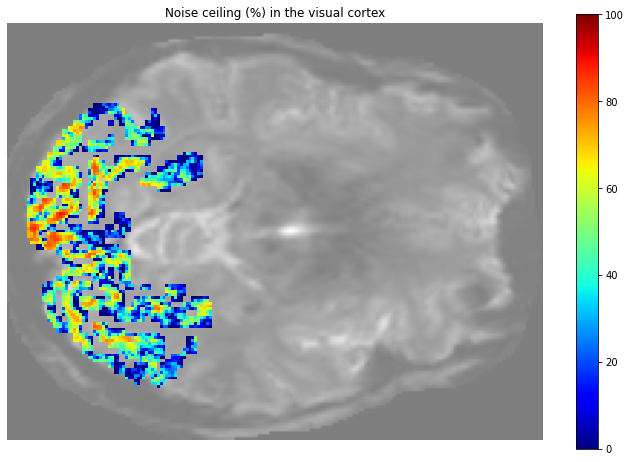

In [290]:
# we are going to plot noiseceiling as an overlay
# which contains the full set of GLMsingle optimizations.

meanvol = np.squeeze(np.mean(data[0].reshape(xyzt),3))
brainmask = meanvol > 275

plt.figure(figsize=(12,8))

plot_data = noiseceiling
#plot_data[~brainmask & roi==1] = np.nan # remove values outside the brain for visualization purposes
plot_data[roi!=1] = np.nan # remove values outside the brain for visualization purposes

plt.imshow(meanvol/np.nanmax(meanvol),
               aspect='auto',cmap='gray',clim=(0,1), alpha=0.5)

plt.imshow(plot_data,cmap='jet',clim=(0,100),interpolation='none')
plt.colorbar()
plt.title("Noise ceiling (%) in the visual cortex")
plt.axis(False)
